In [3]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.utils import check_random_state

plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)

DATA_TRANSFORMED = "../data/transformed"
TRAIN_FEAT = os.path.join(DATA_TRANSFORMED, "train-features")
TEST_FEAT = os.path.join(DATA_TRANSFORMED, "test-features.parquet")

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [4]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include=["float64"]).columns:
        df[c] = df[c].astype("float32")
    for c in df.select_dtypes(include=["int64", "int32"]).columns:
        # item_contact может быть float/int — приведём к int8 (0/1)
        if c == "item_contact":
            df[c] = df[c].astype("int8")
        else:
            df[c] = df[c].astype("int32")
    return df


train = pd.read_parquet(TRAIN_FEAT)
test = pd.read_parquet(TEST_FEAT)

train = downcast_df(train)
test = downcast_df(test)

print(train.shape, test.shape)
train.head(2)


(7781790, 15) (335348, 14)


,query_id,item_id,item_contact,price_log,price_norm,click_conv,query_text_len_chars,query_text_len_words,item_title_len_chars,item_title_len_words,item_description_len_chars,item_description_len_words,match_cat,match_mcat,match_loc
0,4,-1240217310,0,6.216606,1.0,0.0,23,4,20,3,138,24,1,0,0
1,4,-1070199306,0,5.525453,1.0,0.0,23,4,28,4,36,5,1,0,0


In [5]:
ID_COLS = ["query_id", "item_id"]
TARGET_COL = "item_contact"

# все остальные — фичи
FEATURE_COLS = [c for c in train.columns if c not in ID_COLS + [TARGET_COL]]

X = train[FEATURE_COLS].copy()
y = train[TARGET_COL].astype("float32").values
groups = train["query_id"].values

print("n_features:", len(FEATURE_COLS))
FEATURE_COLS


n_features: 12


['price_log',
 'price_norm',
 'click_conv',
 'query_text_len_chars',
 'query_text_len_words',
 'item_title_len_chars',
 'item_title_len_words',
 'item_description_len_chars',
 'item_description_len_words',
 'match_cat',
 'match_mcat',
 'match_loc']

In [6]:
def calc_dcg_at_k(v: np.ndarray, k: int = 10) -> float:
    w = 0.97 ** np.arange(len(v))
    return (v * w)[:k].sum()


def calc_idcg_at_k(v: np.ndarray, k: int = 10) -> float:
    return calc_dcg_at_k(np.sort(v)[::-1], k)


def calc_ndcg_at_k(v: np.ndarray, k: int = 10) -> float:
    denom = calc_idcg_at_k(v, k)
    if denom == 0:
        return 0.0
    return calc_dcg_at_k(v, k) / denom


def ndcg_at_10_by_queries(
    y_true: np.ndarray, y_pred: np.ndarray, qids: np.ndarray, k: int = 10
) -> float:
    # считаем NDCG по каждому query_id, затем усредняем
    order = np.argsort(qids, kind="mergesort")
    qids_sorted = qids[order]
    y_true_s = y_true[order]
    y_pred_s = y_pred[order]

    uniq, starts = np.unique(qids_sorted, return_index=True)
    starts = list(starts) + [len(qids_sorted)]

    scores = []
    for i in range(len(uniq)):
        s, e = starts[i], starts[i + 1]
        yt = y_true_s[s:e]
        yp = y_pred_s[s:e]
        # сортировка по предсказанным скором по убыванию
        idx = np.argsort(-yp, kind="mergesort")
        v = yt[idx]
        scores.append(calc_ndcg_at_k(v, k))
    return float(np.mean(scores)) if scores else 0.0


In [7]:
N_SPLITS = 5  # можно 3 для скорости
gkf = GroupKFold(n_splits=N_SPLITS)

params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "eval_at": [10],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "max_depth": -1,
    "verbosity": -1,
    "random_state": RANDOM_STATE,
}

oof_pred = np.zeros(len(train), dtype=np.float32)
models = []
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, y_tr, q_tr = X.iloc[tr_idx], y[tr_idx], groups[tr_idx]
    X_va, y_va, q_va = X.iloc[va_idx], y[va_idx], groups[va_idx]

    # LightGBM требует group как массив размеров групп по порядку объектов
    def group_sizes(qids):
        _, counts = np.unique(qids, return_counts=True)
        return counts

    lgb_tr = lgb.Dataset(X_tr, y_tr, group=group_sizes(q_tr), free_raw_data=False)
    lgb_va = lgb.Dataset(
        X_va, y_va, group=group_sizes(q_va), reference=lgb_tr, free_raw_data=False
    )

    booster = lgb.train(
        params,
        lgb_tr,
        num_boost_round=5000,
        valid_sets=[lgb_tr, lgb_va],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=100),
        ],
    )

    pred_va = booster.predict(X_va, num_iteration=booster.best_iteration)
    oof_pred[va_idx] = pred_va

    ndcg10 = ndcg_at_10_by_queries(y_va, pred_va, q_va, k=10)
    fold_scores.append(ndcg10)
    models.append(booster)

    print(f"[Fold {fold}] NDCG@10 = {ndcg10:.5f}, best_iter={booster.best_iteration}")

cv_mean = float(np.mean(fold_scores))
cv_std = float(np.std(fold_scores))
print(f"\nCV NDCG@10: {cv_mean:.5f} ± {cv_std:.5f}")


[100]	train's ndcg@10: 0.818536	valid's ndcg@10: 0.808585
[Fold 1] NDCG@10 = 0.27441, best_iter=12
[100]	train's ndcg@10: 0.818112	valid's ndcg@10: 0.808722
[Fold 2] NDCG@10 = 0.27473, best_iter=88
[100]	train's ndcg@10: 0.818048	valid's ndcg@10: 0.810023
[200]	train's ndcg@10: 0.823512	valid's ndcg@10: 0.810342
[300]	train's ndcg@10: 0.827997	valid's ndcg@10: 0.81047
[Fold 3] NDCG@10 = 0.27432, best_iter=270
[100]	train's ndcg@10: 0.818457	valid's ndcg@10: 0.808971
[Fold 4] NDCG@10 = 0.27650, best_iter=89
[100]	train's ndcg@10: 0.819118	valid's ndcg@10: 0.807746
[200]	train's ndcg@10: 0.824487	valid's ndcg@10: 0.807677
[Fold 5] NDCG@10 = 0.27745, best_iter=150

CV NDCG@10: 0.27548 ± 0.00126


OOF NDCG@10 (на всех фолдах): 0.27548


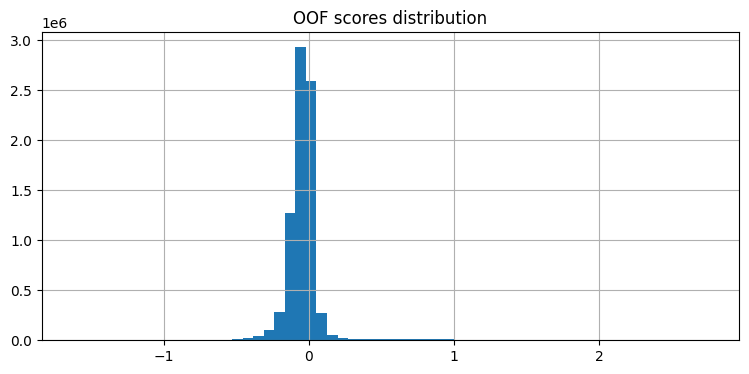

In [8]:
oof_ndcg10 = ndcg_at_10_by_queries(y_true=y, y_pred=oof_pred, qids=groups, k=10)
print(f"OOF NDCG@10 (на всех фолдах): {oof_ndcg10:.5f}")

plt.figure()
plt.hist(oof_pred, bins=60)
plt.title("OOF scores distribution")
plt.show()


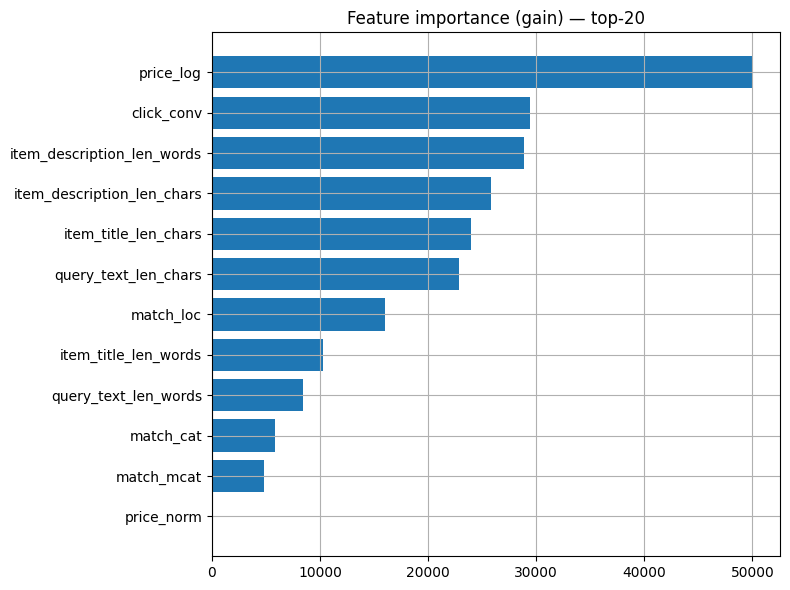

,feature,gain
0,price_log,50047.729067
2,click_conv,29440.605906
8,item_description_len_words,28905.477021
7,item_description_len_chars,25782.348098
5,item_title_len_chars,23965.256050
3,query_text_len_chars,22814.660719
11,match_loc,16022.099297
6,item_title_len_words,10323.247725
4,query_text_len_words,8445.631094
9,match_cat,5819.969518


In [9]:
importances = pd.DataFrame(
    {
        "feature": FEATURE_COLS,
        "gain": np.mean(
            [m.feature_importance(importance_type="gain") for m in models], axis=0
        ),
    }
)
imp_top = importances.sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"][::-1], imp_top["gain"][::-1])
plt.title("Feature importance (gain) — top-20")
plt.tight_layout()
plt.show()

imp_top


In [10]:
def group_sizes_ordered(qids: np.ndarray) -> np.ndarray:
    # порядок уже как в X/y; считаем подряд
    _, counts = np.unique(qids, return_counts=True)
    return counts


train_full = lgb.Dataset(X, y, group=group_sizes_ordered(groups), free_raw_data=False)

final_model = lgb.train(
    params,
    train_full,
    num_boost_round=int(np.mean([m.best_iteration for m in models])),
    valid_sets=[train_full],
    valid_names=["train"],
    callbacks=[lgb.log_evaluation(period=200)],
)

final_path = os.path.join(MODEL_DIR, "lgbm_ranker.txt")
final_model.save_model(final_path)
print("Saved model to:", final_path)


Saved model to: ../models/lgbm_ranker.txt


In [11]:
# OOF
oof_df = train[["query_id", "item_id", TARGET_COL]].copy()
oof_df["oof_score"] = oof_pred.astype("float32")
oof_out = os.path.join(DATA_TRANSFORMED, "oof_scores.parquet")
oof_df.to_parquet(oof_out, index=False)
print("Saved OOF:", oof_out)

# Test scores
test_scores = test[["query_id", "item_id"]].copy()
test_scores["score"] = final_model.predict(test[FEATURE_COLS])
test_out = os.path.join(DATA_TRANSFORMED, "test_scores.parquet")
test_scores.to_parquet(test_out, index=False)
print("Saved test scores:", test_out)


Saved OOF: ../data/transformed/oof_scores.parquet
Saved test scores: ../data/transformed/test_scores.parquet


In [12]:
# сортируем внутри query_id по score убыв.
sub = test_scores.sort_values(["query_id", "score"], ascending=[True, False])[
    ["query_id", "item_id"]
]
sub_path = os.path.join("../data", "solution.csv")
sub.to_csv(sub_path, header=["query_id", "item_id"], index=False)
print("Saved submission:", sub_path)
sub.head()


Saved submission: ../data/solution.csv


,query_id,item_id
4,55,-1037478907
14,55,-1033977595
27,55,-1013267697
2,55,-1184233434
19,55,-659781453
